In [1]:
import numpy as np
import pickle
from scipy import io
import load_data as ld
import sys
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
import pdb
import time
from scipy import interpolate
from matplotlib.pyplot import figure
from scipy.special import logsumexp
np.random.seed(42)

In [2]:
#odometry

In [3]:
#np.set_printoptions(threshold=sys.maxsize)

In [4]:
def side(w1,w2):
    return np.add(w1, w2)*(np.pi * 254 / 360.0)/2.0

In [5]:
def Rtheta(rs,ls):
    width = 733
    theta = np.subtract(rs,ls) / width
    for i in range(1,len(theta)):
        theta[i]+=theta[i-1]
    R = (rs + ls) / (2 * (theta+np.exp(-100)))
    return R, theta

In [6]:
def delta_px_py(rs, ls, theta):
    df = (rs + ls) / 2.0
    dpx = df * np.cos(theta)
    dpy = df * np.sin(theta) 
    return dpx, dpy 

In [7]:
def sum_xy(dpx, dpy):
    for i in range(1,len(dpx)):
        dpx[i]+=dpx[i-1]
        dpy[i]+=dpy[i-1]
    return dpx/1000, dpy/1000

In [8]:
enc_files=['Encoders20','Encoders21','Encoders23']
lidar_files=['Hokuyo20','Hokuyo21','Hokuyo23']
imu_files=['imu20','imu21','imu23']

In [9]:
def odometry(f):
    file = 'data/'+f
    FR, FL, RR, RL, ts = ld.get_encoder('data/'+ str(f))
    rs = side(FR, RR)
    ls = side(FL, RL)
    R, theta=Rtheta(rs,ls)
    dpx, dpy = delta_px_py(rs, ls, theta)
    dpx, dpy = sum_xy(dpx, dpy)
    return dpx,dpy,theta,ts

In [10]:
dpx,dpy,theta,ts={},{},{},{}
for f in range(len(enc_files)):
    dpx[f],dpy[f],theta[f],ts[f]= odometry(enc_files[f])

In [11]:
theta

{0: array([0.        , 0.        , 0.        , ..., 0.13456655, 0.13456655,
        0.13456655]),
 1: array([ 0.        ,  0.        ,  0.        , ..., -0.04384753,
        -0.04384753, -0.04384753]),
 2: array([0.        , 0.        , 0.        , ..., 3.54711383, 3.54711383,
        3.54711383])}

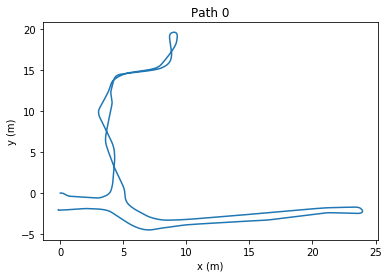

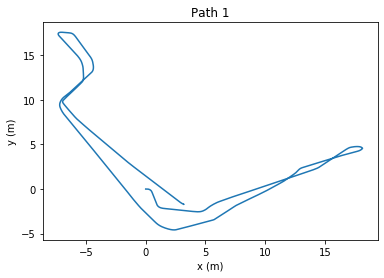

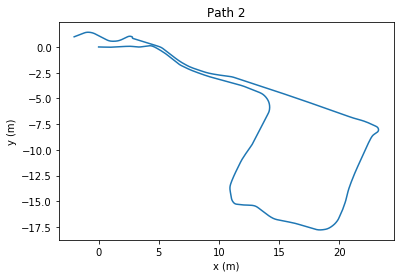

In [12]:
#Print Paths
for i in range(len(dpx)):
    plt.plot(dpx[i],dpy[i])
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Path '+str(i))
    plt.show()

In [13]:
#load lidar

In [14]:
def load_lidar(f):
    file = 'data/'+f
    lidar_data = ld.get_lidar('data/'+ str(f))
    ts_lidar = [ ts['t'] for ts in lidar_data ] 
    return ts_lidar,lidar_data

In [15]:
def find_idx(ts_lid,ts_odo):
    arr=np.searchsorted(ts_lid,ts_odo)
    res=np.zeros((len(arr),1)).astype(np.int)
    for i in range(len(ts_odo)):
        idx=arr[i]
        if idx==len(ts_lid):
            res[i]=idx-1
        elif idx>0: 
            if (abs(ts_odo[i]-ts_lid[idx-1]))>(abs(ts_odo[i]-ts_lid[idx])):
                res[i]=idx
            else:
                res[i]=idx-1
    return res

In [16]:
#match timestamps

In [17]:
ts_match,lidar_data={},{}
for f in range(len(lidar_files)):
    ts_lid,lidar_data[f] = load_lidar(lidar_files[f])
    ts_match[f]=find_idx(ts_lid,ts[f])

In [18]:
#drop extra lidar scans

In [19]:
lidar_new={}
for f in range(len(lidar_data)):
    lidar_new[f] = np.take(lidar_data[f],ts_match[f])

In [20]:
#Polar to Cart

In [21]:
def p2c(r, theta,th):
    
    r=np.reshape(r,(len(r),1))
    theta=np.reshape(theta,(len(theta),1))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    xn=x*np.cos(th)-y*np.sin(th)
    yn=x*np.sin(th)+y*np.cos(th)
    return xn, yn

In [22]:
for f in range(len(lidar_new)):
    for i in range((len(lidar_new[f]))):
        lidar_new[f][i][0]['x'],lidar_new[f][i][0]['y']=p2c(lidar_new[f][i][0]['scan'],lidar_new[f][i][0]['angle'],theta[f][i])

In [23]:
lidar_new[0][0][0]['x']

array([[-2.38648539],
       [-2.3760497 ],
       [-2.37047511],
       ...,
       [-3.44146438],
       [-3.45671219],
       [-3.47189419]])

In [24]:
#Plot on map

In [25]:
def bresenham2D(sx, sy, ex, ey):
    sx = np.int(round(sx))
    sy = np.int(round(sy))
    ex = np.int(round(ex))
    ey = np.int(round(ey))
    dx = abs(ex-sx)
    dy = abs(ey-sy)
    steep = abs(dy)>abs(dx)
    if steep:
        dx,dy = dy,dx # swap 
    if dy == 0:
        q = np.zeros((dx+1,1))
    else:
        q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
    if steep:
        if sy <= ey:
            y = np.arange(sy,ey+1)
        else:
            y = np.arange(sy,ey-1,-1)
        if sx <= ex:
            x = sx + np.cumsum(q)
        else:
            x = sx - np.cumsum(q)
    else:
        if sx <= ex:
            x = np.arange(sx,ex+1)
        else:
            x = np.arange(sx,ex-1,-1)
        if sy <= ey:
            y = sy + np.cumsum(q)
        else:
            y = sy - np.cumsum(q)
    return np.vstack((x,y)).astype(np.int)

In [26]:
def create_map(lidar_maps,dx,dy,size,res,mu):
    lnum=0
    dmap=np.zeros((size+1,size+1))
    for i in range(len(dx)):
        start = time.time()
        x=(np.round(lidar_maps[i][0]['x']+dx[i],mu)*res+size/2).astype(np.int)
        y=(np.round(lidar_maps[i][0]['y']+dy[i],mu)*res+size/2).astype(np.int)
        
        for j in range(len(x)):
            if x[j][0]<=size+1 and y[j][0]<=size+1 :
                dxx=(dx[i]*res+size/2)
                dyy=(dy[i]*res+size/2)
                #if np.sqrt((x[j][0]-dxx)**2+(y[j][0]-dyy)**2)>20:
                arr=bresenham2D(dxx,dyy,x[j][0],y[j][0])
                dmap[arr[0,:-1],arr[1,:-1]]-=0.5
                dmap[arr[0,-1:],arr[1,-1:]]+=0.9
                
                    
        lnum+=1
        if lnum==1:
            print('Estimated runtime: ',(time.time() - start)*len(dx)/60)
    return dmap,lnum

Estimated runtime:  5.281408596038818


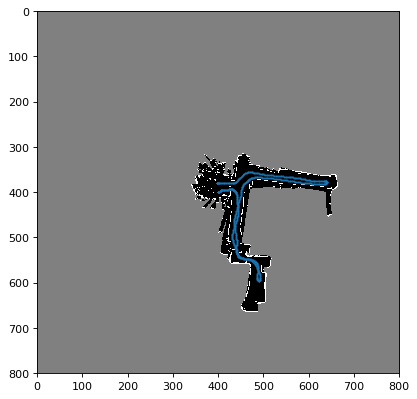

Estimated runtime:  5.2715524991353355


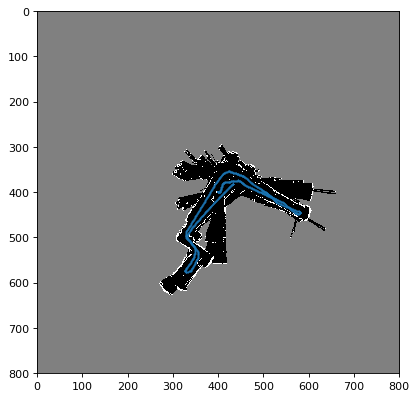

Estimated runtime:  3.863802397251129


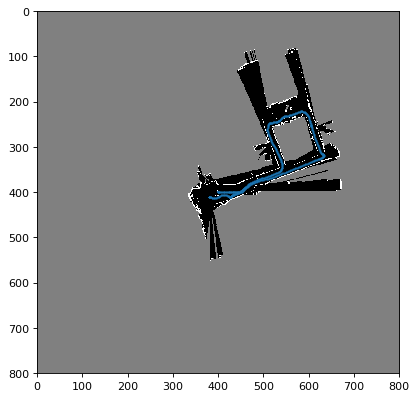

In [27]:
for f in range(len(lidar_new)):
    size,res,mu=800,10,1
    dmap,lnum = create_map(lidar_new[f],dpx[f],dpy[f],size,res,mu)
    dmap=np.where(dmap<0,-1,dmap)
    dmap=np.where(dmap>0,1,dmap)
    convert_gray=interpolate.interp1d([-1,1],[0,255])
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(np.round(dpx[f],mu)*res+size/2,np.round(dpy[f],mu)*res+size/2,s=0.1,alpha=0.5)
    plt.imshow(convert_gray(dmap.T),cmap='gray')
    plt.show()

##### SLAM

In [28]:
def add_noise(x,p,std):
    return np.random.normal(x, std, p-1)

In [29]:
def Rtheta_noisy(rs,ls,p,std):
    width = 733
    init_theta = np.subtract(rs,ls) / width
    theta = np.zeros((len(init_theta),p))
    R = np.zeros((len(init_theta),p))
    theta[:,0]=init_theta
    theta[0,1:]=add_noise(theta[0,0],p,std)
    
    for i in range(1,len(theta)):
        theta[i,1:]=add_noise(theta[i,0],p,std)
        theta[i,:]+=theta[i-1,:]
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            R[i,j] = (rs[i] + ls[i]) / (2 * (theta[i,j]+np.exp(-100)))
    return R, theta

In [30]:
def delta_px_py_noisy(rs, ls, theta,p,std):
    dpx =  np.zeros((theta.shape))
    dpy =  np.zeros((theta.shape))
    df = (rs + ls) / 2.0
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            dpx[i,j] = df[i] * np.cos(theta[i,j])
            dpy[i,j] = df[i] * np.sin(theta[i,j]) 
            if j>0:
                dpx[i,j] = add_noise(dpx[i,j],2,std)
                dpy[i,j] = add_noise(dpy[i,j],2,std)
    return dpx, dpy 

In [31]:
def sum_xy_noisy(dpx, dpy):
    for i in range(1,len(dpx)):
        dpx[i,:]+=dpx[i-1,:]
        dpy[i,:]+=dpy[i-1,:]
    return dpx/1000, dpy/1000

In [32]:
def odo_noisy(f,p,std):
    file = 'data/'+f
    FR, FL, RR, RL, ts = ld.get_encoder('data/'+ str(f))
    rs = side(FR, RR)
    ls = side(FL, RL)
    R,theta = Rtheta_noisy(rs,ls,p,std)
    dpx,dpy = delta_px_py_noisy(rs, ls, theta,p,std)
    dpx,dpy = sum_xy_noisy(dpx, dpy)
    return dpx,dpy,theta,ts

In [33]:
def gen_init_map(lidar_maps,dx,dy,size,res,mu):
    lnum=0
    dmap=np.zeros((size+1,size+1))
    x=(np.round(lidar_maps[0][0]['x']+dx,mu)*res+size/2).astype(np.int)
    y=(np.round(lidar_maps[0][0]['y']+dy,mu)*res+size/2).astype(np.int)
    for j in range(len(x)):
            arr=bresenham2D((dx*res+size/2),(dy*res+size/2),x[j][0],y[j][0])
            dmap[arr[0,:-1],arr[1,:-1]]-=0.7
            dmap[arr[0,-1:],arr[1,-1:]]+=0.9
    lnum+=1
    return dmap,lnum

In [34]:
def step_corr(lidar_maps,dx,dy,dmap,res,size,mu,i):
    #print(dx,dy)
    x=(np.round(lidar_maps[i][0]['x']+dx,mu)*res+size/2).astype(np.int)
    y=(np.round(lidar_maps[i][0]['y']+dy,mu)*res+size/2).astype(np.int)
    sums=0
    for j in range(len(x)):
            if abs(x[j][0])<size+1 and abs(y[j][0])<size+1:
            #if dmap[x[j],y[j]][0]>0:
                sums+=dmap[x[j],y[j]][0]
    return sums

In [35]:
def update_map(lidar_maps,dx,dy,size,res,mu,dmap,i):
    x=(np.round(lidar_maps[i][0]['x']+dx,mu)*res+size/2).astype(np.int)
    y=(np.round(lidar_maps[i][0]['y']+dy,mu)*res+size/2).astype(np.int)
    for j in range(len(x)):
        if abs(x[j][0])<size+1 and abs(y[j][0])<size+1:
            arr=bresenham2D((dx*res+size/2),(dy*res+size/2),x[j][0],y[j][0])
            dmap[arr[0,:-1],arr[1,:-1]]-=0.5
            dmap[arr[0,-1:],arr[1,-1:]]+=0.9
    return dmap

In [36]:
def stratified(weights):#https://filterpy.readthedocs.io/en/latest/_modules/filterpy/monte_carlo/resampling.html#stratified_resample
    N = len(weights)
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    positions = np.random.uniform(low=min(cumulative_sum), high=max(cumulative_sum), size=(N,))
    i, j = 0, 0
    while i < N:
        if positions[i] > cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [37]:
def new_part(particles, weights):
    largest = weights.argsort()[-5:][::-1]
    smallest = weights.argsort()[:15][::]
    particles[smallest]=np.concatenate([np.concatenate([particles[largest],particles[largest]]),particles[largest]])
    return  particles

In [38]:
def resample(p_dpx,p_dpy,k,weights,step,p,std):

   # p_dpx[k,1:]=new_part(p_dpx[k,1:],weights[1:])
    p_dpx[k,1:] = p_dpx[k,stratified(weights[1:])]
    
    for i in range(k,step+k+1):
        p_dpx[i+1,1:] = p_dpx[i,1:] + (p_dpx[i+1,0]-p_dpx[i,0]) 
        for j in range(1,p):
            b=p_dpx[i+1,j]
            n=add_noise(p_dpx[i+1,j],2,std)
            p_dpx[i+1,j] = n
    weights[:]=np.log(1/p)
    return p_dpx,p_dpy,weights

Estimated runtime:  15.947556924819946


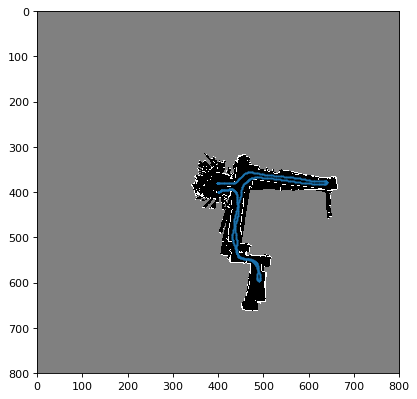

Estimated runtime:  16.24402633905411


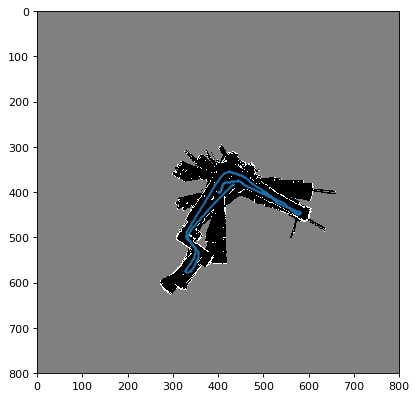

Estimated runtime:  12.914395387967428


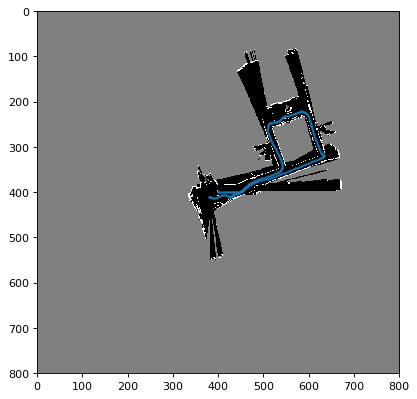

In [39]:
for f in range(0,len(lidar_new)):
    p,std,step=30,0.0002,300
    weights=np.zeros((p))
    weights[:]=np.log(1/p)
    
    p_dpx,p_dpy,p_theta,ts = odo_noisy(enc_files[f],p,std)
    size,res,mu=800,10,1
    dmap,lnum = gen_init_map(lidar_new[f],p_dpx[0][0],p_dpy[0][0],size,res,mu)
    
    for i in range(1,p_dpx.shape[0]):
        start = time.time()
        temp=[]
        for j in range(p_dpx.shape[1]):
            temp.append(step_corr(lidar_new[f],p_dpx[i,j],p_dpy[i,j],dmap,res,size,mu,i))
        
        weights+=temp
        #print(weights)
        k=np.random.choice(np.flatnonzero(weights == weights.max()))
        dmap=update_map(lidar_new[f],p_dpx[i,k],p_dpy[i,k],size,res,mu,dmap,i)
        if i==1:
            print('Estimated runtime: ',(time.time() - start)*p_dpx.shape[0]/60)
        #print(i,k)
        
        if i%step==0 and (p_dpx.shape[0]-i)>=step:
            p_dpx,p_dpy,weights=resample(p_dpx,p_dpy,i,weights,step,p,std)
        
    dmap=np.where(dmap<0,-1,dmap)
    dmap=np.where(dmap>0,1,dmap)
    convert_gray=interpolate.interp1d([-1,1],[0,255])
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(np.round(dpx[f],mu)*res+size/2,np.round(dpy[f],mu)*res+size/2,s=0.1,alpha=0.5)
    plt.imshow(convert_gray(dmap.T),cmap='gray')
    plt.show()